In [28]:
import zipfile
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

root = 'E:/Data/Kaggle'
dataDir = f'{root}/dont-overfit-ii'
Z = zipfile.ZipFile(f'{dataDir}.zip')
Z.extractall(dataDir)

trainset = pd.read_csv(f'{dataDir}/train.csv')
testset = pd.read_csv(f'{dataDir}/test.csv')
submit = pd.read_csv(f'{dataDir}/sample_submission.csv')

比赛：https://www.kaggle.com/c/dont-overfit-ii

In [25]:
trainset.head()

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,...,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,...,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,...,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,...,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,...,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253


In [26]:
trainset.shape

(250, 302)

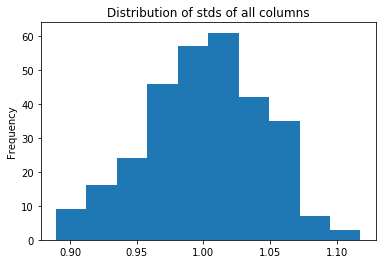

In [30]:
trainset[trainset.columns[2:]].std().plot('hist');
plt.title('Distribution of stds of all columns');

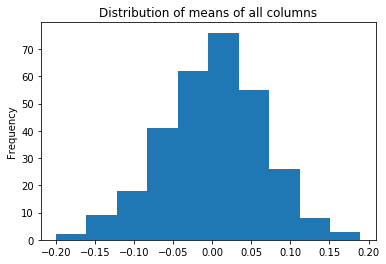

In [31]:
trainset[trainset.columns[2:]].mean().plot('hist');
plt.title('Distribution of means of all columns');

In [32]:
# we have no missing values
trainset.isnull().any().any()

False

Distributions of first 28 columns


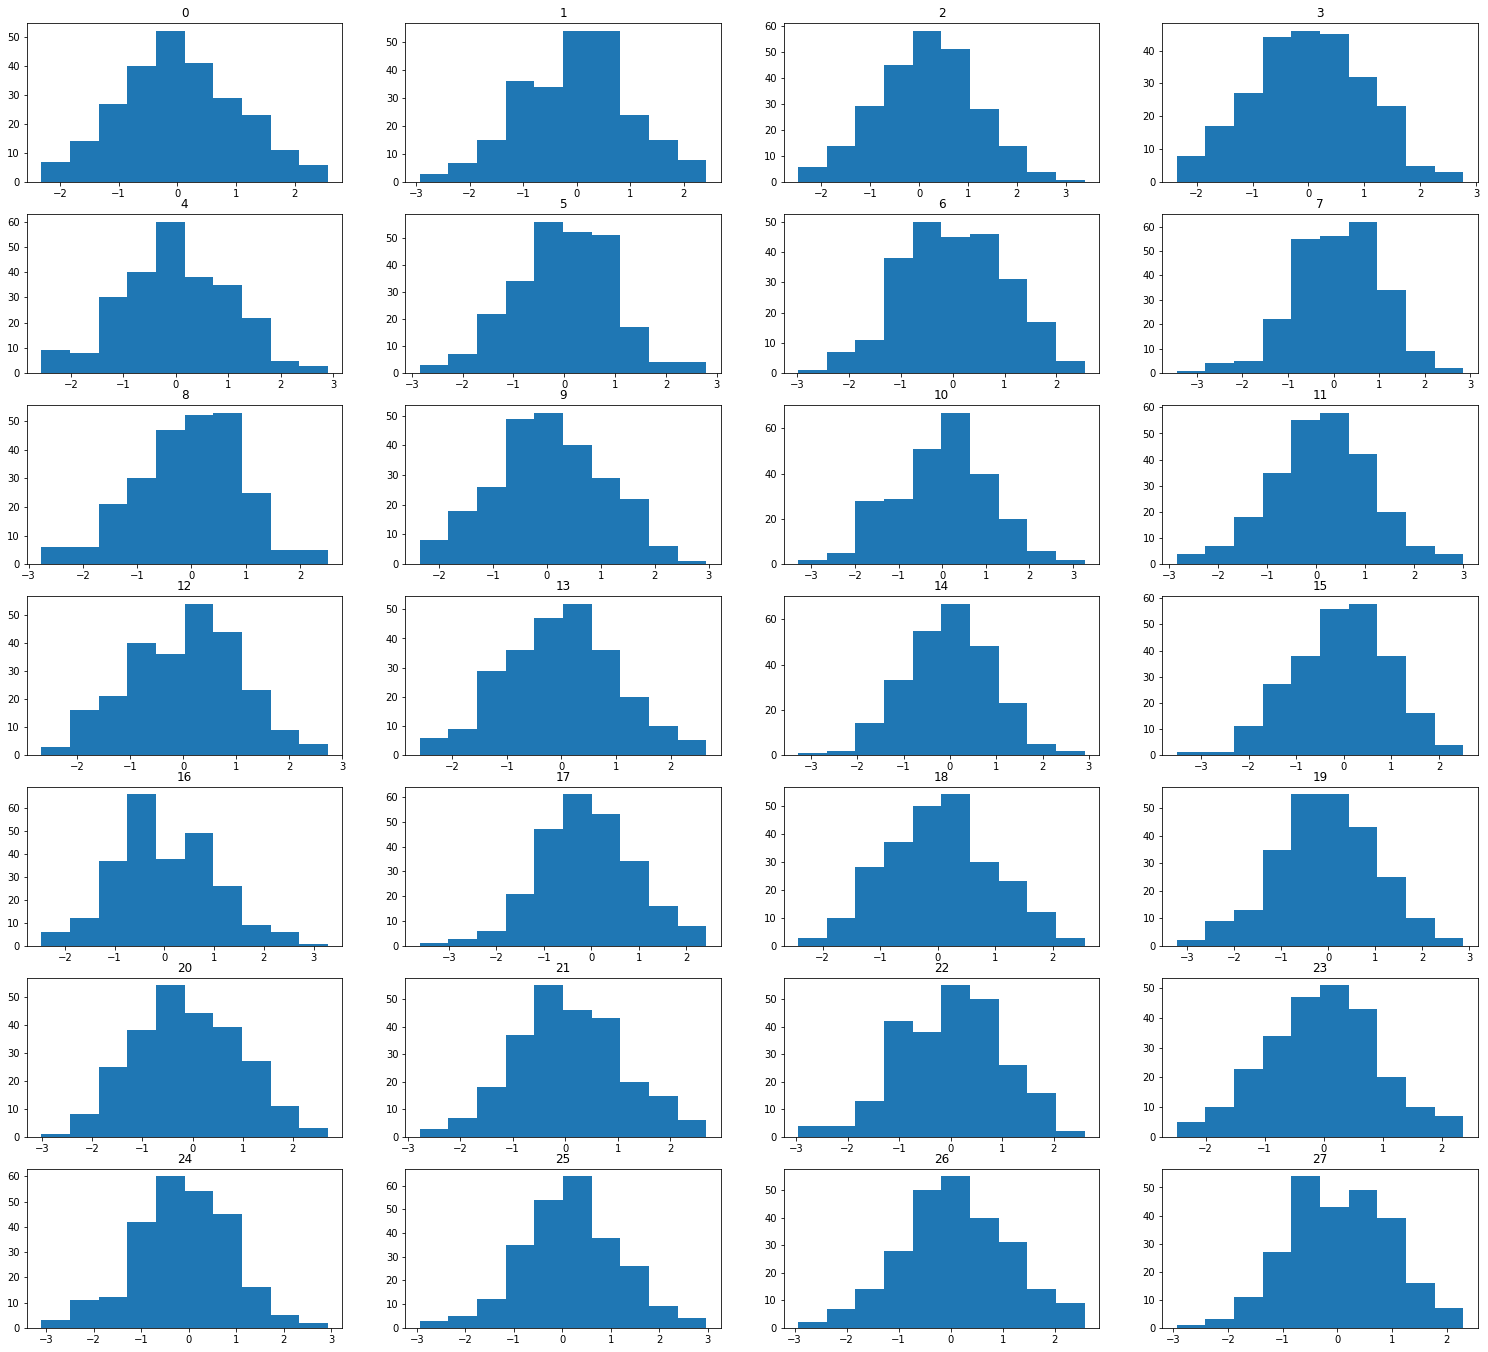

In [34]:
print('Distributions of first 28 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(list(trainset.columns)[2:30]):
    plt.subplot(7, 4, i + 1)
    plt.hist(trainset[col])
    plt.title(col)

In [35]:
trainset['target'].value_counts()

1.0    160
0.0     90
Name: target, dtype: int64

From this overview we can see the following things:

- target is binary and has some disbalance: $36\%$ of samples belong to 0 class;
- values in columns are more or less similar;
- columns have std of $1 +/- 0.1$ (min and max values are $0.889$, $1.117$ respectively);
- columns have mean of $0 +/- 0.15$ (min and max values are $-0.2$, $0.1896$ respectively);

In [37]:
corrs = trainset.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(10)

,level_0,level_1,0
90892,22,28,0.246062
90893,28,22,0.246062
90894,193,101,0.252825
90895,101,193,0.252825
90896,75,32,0.259315
90897,32,75,0.259315
90898,target,65,0.293846
90899,65,target,0.293846
90900,33,target,0.373608
90901,target,33,0.373608


We can see that correlations between features are lower that $0.3$ and the most correlated feature with target has correlation of $0.37$. So we have no highly correlated features which we could drop, on the other hand we could drop some columns with have little correlation with the target.

In [45]:
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

X_train = trainset.drop(['id', 'target'], axis=1)
y_train = trainset['target']
X_test = testset.drop(['id'], axis=1)
n_fold = 10
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
repeated_folds = RepeatedStratifiedKFold(n_splits=10, n_repeats=20)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [46]:
def train_model(X, X_test, y, params, folds=folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        # print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]

        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)

            model = lgb.train(params,
                              train_data,
                              num_boost_round=2000,
                              valid_sets=[train_data, valid_data],
                              verbose_eval=500,
                              early_stopping_rounds=200)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)

        if model_type == 'xgb':
            train_data = xgb.DMatrix(
                data=X_train, label=y_train, feature_names=X_tr.columns)
            valid_data = xgb.DMatrix(
                data=X_valid, label=y_valid, feature_names=X_tr.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist,
                              early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(
                X_valid, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(
                X_test, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)

        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')

            y_pred = model.predict_proba(X_test)[:, 1]

        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values

        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat(
                [feature_importance, fold_importance], axis=0)

    prediction /= n_fold

    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(
        np.mean(scores), np.std(scores)))

    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(
                cols)]

            plt.figure(figsize=(16, 12))
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(
                by="importance", ascending=False))
            plt.title('LGB Features (avg over folds)')

            return oof, prediction, feature_importance
        return oof, prediction, scores

    else:
        return oof, prediction, scores

In [47]:
from sklearn import linear_model
# A lot of people are using logreg currently, let's try
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr, prediction_lr, scores = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)

CV mean score: 0.7226, std: 0.0586.


In [48]:
model = linear_model.LogisticRegression(
    class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr, prediction_lr_repeated, scores = train_model(
    X_train,
    X_test,
    y_train,
    params=None,
    model_type='sklearn',
    model=model,
    folds=repeated_folds)

CV mean score: 0.7066, std: 0.0872.


In [50]:
from sklearn.model_selection import GridSearchCV

lr = linear_model.LogisticRegression(solver='liblinear', max_iter=1000)

parameter_grid = {'class_weight' : ['balanced', None],
                  'penalty' : ['l2'],
                  'C' : [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                  'solver': ['newton-cg', 'sag', 'lbfgs']
                 }

grid_search = GridSearchCV(lr, param_grid=parameter_grid, cv=folds, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Best score: 0.7625
Best parameters: {'C': 10.0, 'class_weight': None, 'penalty': 'l2', 'solver': 'newton-cg'}


In [51]:
lr = linear_model.LogisticRegression(solver='liblinear', max_iter=1000)

parameter_grid = {'class_weight' : ['balanced', None],
                  'penalty' : ['l2', 'l1'],
                  'C' : [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                 }

grid_search = GridSearchCV(lr, param_grid=parameter_grid, cv=folds, scoring='roc_auc')
grid_search.fit(X_train, y_train)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8027777777777779
Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1'}


In [52]:
model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr, prediction_lr, scores = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)

CV mean score: 0.7226, std: 0.0586.
